# 循环神经网络的在线学习

在[关键概念](./concepts-zh.ipynb)一章中，我们介绍了`braintrace`在线学习的基础知识。在本节中，我们将讨论如何基于``braintrace``进行循环神经网络（Recurrent Neural Networks，RNNs）的在线学习。

基于发放率的循环神经网络（Rate-based RNNs）相比于脉冲神经网络（Spiking Neural Networks，SNNs）更广泛地应用于目前的深度学习任务中。在这种网络中，神经元的输出是连续的浮点数，而非像SNNs中的离散脉冲。``braintrace``提供的``ParamDimVjpAlgorithm``算法可以非常高效地用于支持RNNs的在线学习。

In [ ]:
import brainstate
import braintrace
import braintools

## 1. RNNs基本概念

循环神经网络是专门设计用于处理序列数据的神经网络架构。它们在自然语言处理、时间序列预测、语音识别等领域得到了广泛应用。

**RNNs的数学模型**

RNNs的一个关键特性是它们可以处理任意长度的输入序列，并且可以捕捉序列中的时间依赖关系。RNNs的典型结构如下：

![RNNs](../_static/architecture-rnn-ltr.png)

对于每个时间步$a^{<t>}$，激活$y^{<t>}$是由输入$x^{<t>}$和前一个时间步的激活$a^{<t-1>}$计算得到的。$a^{<t>}$和$y^{<t>}$的计算公式如下：

$$
\begin{aligned}
a^{<t>}=&g_{1}(W_{a a}a^{<t-1>}+W_{a x}x^{<t>}+b_{a}) \\
y^{<t>}=&g_{2}(W_{y a}a^{<t>}+b_{y})
\end{aligned}
$$

其中，${\mathcal{W}}_{ax},\;{\mathcal{W}}_{a a},\;{\mathcal{W}}_{y a},\;b_{a},\;b_{y} $ 是时间上共享的系数，$g_1$和$g_2$ 是激活函数。在训练过程中，我们需要通过梯度下降算法来更新这些参数。


**RNNs的应用**

RNNs可以应用于多种不同的任务，包括：自然语言处理（NLP）、时间序列预测、语音识别等。下表总结了不同的应用领域：

![RNNs Applications](../_static/rnn-applications.png)



**RNNs的训练**

RNNs的损失函数 $\mathcal{L}$ 是根据每个时间步的损失定义的，如下所示：

$$
\mathcal{L(\hat{y},y)}=\sum_{t=1}^{T_{y}}\mathcal{L(\hat{y}^{<t>},y^{<t>})}
$$

RNNs往往使用反向传播算法进行训练。在每个时间步，我们计算损失 $\mathcal{L}$ 对权重矩阵 $W$ 的导数。在时间步 $T$，损失 $\mathcal{L}$ 对权重矩阵 $W$ 的导数表示如下：

$$
\frac{\partial{\mathcal{L}}(T)}{\partial W}=\sum_{t=1}^{T}\,\frac{\partial{\mathcal{L}}(T)}{\partial W}\Big|_{(t)}
$$





**RNNs的变体**

为了解决传统RNN在处理序列数据时所面临的几个核心问题，包括梯度消失与梯度爆炸、信息流动控制、上下文理解和复杂数据处理等方面的局限性，研究者们提出了多种RNN的变体，其中最为流行的包括：

1. 长短期记忆（LSTM）：长短期记忆网络（LSTM）由Hochreiter和Schmidhuber于1997年提出，旨在解决传统RNN在处理长期依赖关系时的梯度消失问题。

LSTM单元由三个主要部分组成：

- **遗忘门（Forget Gate）**：决定保留多少来自前一个隐藏状态的信息。
  
  $$
  f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
  $$

- **输入门（Input Gate）**：决定新信息的输入。
  
  $$
  \begin{aligned}
  i_t =& \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) \\
  \tilde{C}_t =& \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)
  \end{aligned}
  $$

- **输出门（Output Gate）**：决定输出多少当前单元状态的信息。

  $$
  \begin{aligned}
  o_t =& \sigma(W_o \cdot [h_{t-1}, x_t] + b_o) \\
  C_t =& f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t \\
  h_t =& o_t \cdot \tanh(C_t)
    \end{aligned}
  $$

2. 门控循环单元（GRU）：是LSTM的简化版本，由Cho等人于2014年提出。GRU保留了LSTM的优势，但具有更少的参数。

GRU只有两个门：

- **重置门（Reset Gate）**：控制前一隐藏状态对当前状态的影响。
 
  $$
  r_t = \sigma(W_r \cdot [h_{t-1}, x_t] + b_r)
  $$

- **更新门（Update Gate）**：决定当前单元状态的更新程度。

  $$
  z_t = \sigma(W_z \cdot [h_{t-1}, x_t] + b_z)
  $$

- **单元状态更新**：

  $$
    \begin{aligned}
  \tilde{h}_t =& \tanh(W \cdot [r_t \cdot h_{t-1}, x_t] + b) \\
  h_t =& (1 - z_t) \cdot h_{t-1} + z_t \cdot \tilde{h}_t
    \end{aligned}
  $$


GRU通过减少门的数量，使得模型更简单且训练更快，同时在许多任务上与LSTM表现相当。



可以看到，这种数学形式下的RNN模型完美满足[关键概念](./concepts-zh.ipynb)中我们所说的“动力学”和"动力学交互"的分离 。因此 ``braintrace`` 的在线学习系统可以很好的支持RNN模型的在线学习。


## 2. ``braintrace``支持的RNN模型

``braintrace``并非支持所有的RNN模型的在线学习。比如，对于最简单的Elman RNNs，

$$
h_t=f(W_hh_{t-1}+W_xx_t+b_h)
$$

``braintrace``并不支持它的在线学习。但是，对于LSTM和GRU等复杂的RNN模型，特别适合使用``braintrace``进行它们的在线学习。主要原因是LSTM和GRU等模型的状态更新是通过门控机制实现的，这些门控机制导致了丰富的状态变量内在动力学。正如[我们论文](https://doi.org/10.1101/2024.09.24.614728)中所展示的，``braintrace``的时序依赖关系的学习就是通过这些逐元素运算状态变量的动力学更新来实现的。

目前，我们可以使用``ParamDimVjpAlgorithm``算法进行任意RNN模型的在线学习。让我们通过一个简单的例子来展示如何使用``braintrace``进行RNN的在线学习。

## 3. 基于复制任务的GRU模型在线学习


### 3.1 复制任务数据集

复制任务（Copying Task）是一种用于测试循环神经网络是否能够记住长时程依赖关系的经典任务。这种任务被广泛用于验证RNN模型在面对长序列信息时的表现，尤其是衡量模型是否能够有效地保留输入信息，避免梯度消失或梯度爆炸的影响。

在典型的复制任务中，模型的目标是将给定的输入序列在一定延迟后准确复制到输出序列。例如，假设输入序列长度为$T$：

- 输入序列的前面部分包含若干个特定符号（如字母或数字），然后跟随一定数量的占位符（如“0”），用以延迟输出的生成。
- 序列的最后一部分则是一个信号，告知模型在接下来的时刻开始输出最初的若干个符号（即最初的输入子序列）。

**举例说明**

```bash
输入序列示例：
"1 5 3 4 8 [等待符号] ... [等待符号] 标记符号 0 0 0 0 0"
期望输出：
"0 0 0 0 0 0 ... 0 1 5 3 4 8"
```

该序列通常包含三部分:（1）需要被记忆的数字序列(如上例中的"1 5 3 4 8")，（2）中间的等待时间段(用特殊符号填充)，（3）触发输出的标记符号。

下面是一个简单的数据加载器示例：

In [2]:
import numpy as np

class CopyDataset:
    def __init__(self, time_lag: int, batch_size: int):
        super().__init__()
        self.seq_length = time_lag + 20
        self.batch_size = batch_size

    def __iter__(self):
        while True:
            ids = np.zeros([self.batch_size, self.seq_length], dtype=int)
            # 随机生成10个数字
            ids[..., :10] = np.random.randint(1, 9, (self.batch_size, 10))
            # 在输入序列最后10位中添加10个占位符
            ids[..., -10:] = np.ones([self.batch_size, 10]) * 9
            # 输入序列
            x = np.zeros([self.batch_size, self.seq_length, 10])
            for i in range(self.batch_size):
                x[i, range(self.seq_length), ids[i]] = 1
            yield x, ids[..., :10]
            

在上面的代码中，我们定义了一个``CopyDataset``类，我们可以使用``__iter__``方法来生成复制任务数据集。在每次迭代中，我们生成一个长度为`time_lag + 20`的序列，其中包含10个随机数字和`time_lag`个占位符。我们的目标是将这10个随机数字复制到输出序列中。

### 3.2 GRU模型定义

我们使用GRU模型来解决复制任务。我们可以使用``braintrace``提供的``GRUCell``模型来定义GRU模型。下面是一个简单的GRU模型定义示例：


In [3]:
class GRUNet(brainstate.nn.Module):
    def __init__(self, n_in, n_rec, n_out, n_layer):
        super().__init__()

        # 构建GRU多层网络
        layers = []
        for _ in range(n_layer):
            layers.append(braintrace.nn.GRUCell(n_in, n_rec))
            n_in = n_rec
        self.layer = brainstate.nn.Sequential(*layers)
        # 构建输出层
        self.readout = braintrace.nn.Linear(n_rec, n_out)

    def update(self, x):
        return self.readout(self.layer(x))

### 3.3 在线学习

接下来，我们首先写一个抽象``Trainer``类，使其能够根据指定的参数对复制任务进行模型训练。然后，我们将实现两个具体的训练器：``OnlineTrainer``和``BPTTTrainer``。``OnlineTrainer``使用``braintrace``的在线学习算法进行训练，而``BPTTTrainer``使用时间反向传播算法（BPTT）进行训练。

In [4]:
import braintools as bts
from tqdm import tqdm
import jax


class Trainer(object):
    def __init__(
        self,
        target: brainstate.nn.Module,
        opt: braintools.optim.Optimizer,
        n_epochs: int,
        n_seq: int,
        batch_size: int = 128,
    ):
        super().__init__()

        # target network
        self.target = target

        # optimizer
        self.opt = opt
        weights = self.target.states().subset(brainstate.ParamState)
        opt.register_trainable_weights(weights)

        # training parameters
        self.n_epochs = n_epochs
        self.n_seq = n_seq
        self.batch_size = batch_size

    def batch_train(self, xs, ys):
        raise NotImplementedError

    def f_train(self):
        dataloader = CopyDataset(self.n_seq, self.batch_size)
        bar = tqdm(enumerate(dataloader), total=self.n_epochs)
        losses = []
        for i, (x_local, y_local) in bar:
            if i == self.n_epochs:
                break
            # training
            x_local = np.transpose(x_local, (1, 0, 2))
            y_local = np.transpose(y_local, (1, 0))
            r = self.batch_train(x_local, y_local)
            bar.set_description(f'Training {i:5d}, loss = {float(r):.5f}', refresh=True)
            losses.append(r)
        return np.asarray(losses)

在上面的代码中，我们定义了一个抽象``Trainer``类，它包含一个``batch_train``方法，在一个批次的数据上训练模型。我们还定义了一个``f_train``方法，用于模型训练的直接入口。

In [5]:
class OnlineTrainer(Trainer):
    @brainstate.transform.jit(static_argnums=(0,))
    def batch_train(self, inputs, target):
        weights = self.target.states(brainstate.ParamState)

        # 对于每一个batch的数据，重新初始化模型状态
        brainstate.nn.init_all_states(self.target, inputs.shape[1])

        # 初始化在线学习模型
        # 此处，我们需要使用 mode 来指定使用数据集是具有 batch 维度的
        model = braintrace.ParamDimVjpAlgorithm(self.target, mode=brainstate.mixin.Batching())

        # 使用一个样例数据编译在线学习eligibility trace
        model.compile_graph(inputs[0])

        def _etrace_loss(inp, tar):
            # call the model
            out = model(inp)

            # calculate the loss
            loss = bts.metric.softmax_cross_entropy_with_integer_labels(out, tar).mean()
            return loss, out

        def _etrace_grad(prev_grads, x):
            inp, tar = x
            # 计算当前时刻的梯度
            f_grad = brainstate.transform.grad(_etrace_loss, weights, has_aux=True, return_value=True)
            cur_grads, local_loss, out = f_grad(inp, tar)
            # 累计梯度
            next_grads = jax.tree.map(lambda a, b: a + b, prev_grads, cur_grads)
            # 返回累计后的梯度和损失函数值
            return next_grads, (out, local_loss)

        def _etrace_train(inputs_):
            # 初始化梯度
            grads = jax.tree.map(lambda a: jax.numpy.zeros_like(a), {k: v.value for k, v in weights.items()})
            # 沿着时间轴计算和累积梯度
            grads, (outs, losses) = brainstate.transform.scan(_etrace_grad, grads, (inputs_, target))
            # 更新梯度
            self.opt.update(grads)
            return losses.mean()

        # 在T时刻之前，模型更新其状态和eligibility trace
        n_sim = self.n_seq + 10
        brainstate.transform.for_loop(model, inputs[:n_sim])

        # 在T时刻之后，模型开始在线学习
        r = _etrace_train(inputs[n_sim:])
        return r


在上面的代码中，我们定义了一个``OnlineTrainer``类，它继承自``Trainer``类。其中，我们使用``braintrace.ParamDimVjpAlgorithm``算法来进行在线学习。在每个时间步，我们计算损失函数的梯度，并使用梯度下降算法来更新模型的参数。

### 3.4 离线学习

为了对比在线学习的性能，我们实现了一个``BPTTTrainer``类，它使用时间反向传播算法（BPTT）进行训练。下面是``BPTTTrainer``类的实现：

In [6]:
class BPTTTrainer(Trainer):
    @brainstate.transform.jit(static_argnums=(0,))
    def batch_train(self, inputs, targets):
        # initialize the states
        brainstate.nn.init_all_states(self.target, inputs.shape[1])

        # 需要求解梯度的参数
        weights = self.target.states(brainstate.ParamState)

        def _run_step_train(inp, tar):
            out = self.target(inp)
            loss = bts.metric.softmax_cross_entropy_with_integer_labels(out, tar).mean()
            return out, loss

        def _bptt_grad_step():
            # 在T时刻之前，模型更新其状态及其eligibility trace
            n_sim = self.n_seq + 10
            _ = brainstate.transform.for_loop(self.target, inputs[:n_sim])
            # 在T时刻之后，模型开始在线学习
            outs, losses = brainstate.transform.for_loop(_run_step_train, inputs[n_sim:], targets)
            return losses.mean(), outs

        # gradients
        grads, loss, outs = brainstate.transform.grad(_bptt_grad_step, weights, has_aux=True, return_value=True)()

        # optimization
        self.opt.update(grads)

        return loss

### 3.5 模型训练比较：在线学习 vs. 离线学习

接下来，我们将在线学习和离线学习的性能进行比较。我们将模型训练100个epoch，并记录每个epoch的损失值。每个epoch包含128个样本，每个样本包含200个序列。

训练在线学习模型：

In [7]:
online = OnlineTrainer(
    target=GRUNet(10, 200, 10, 1),
    opt=braintools.optim.Adam(0.001),
    n_epochs=1000,
    n_seq=200,
    batch_size=128,
)
online_losses = online.f_train()

  0%|          | 0/1000 [00:00<?, ?it/s]/mnt/d/codes/projects/braintrace/braintrace/_etrace_compiler_hid_param_op.py:363: UserWarning: 
We have changed is as a weight that is not trained with eligibility trace. However, if you 
found this is a compilation error, please report an issue to the developers at https://github.com/chaobrain/braintrace/issues. 


  warnings.warn(msg, UserWarning)
/mnt/d/codes/projects/braintrace/braintrace/_etrace_compiler_hid_param_op.py:363: UserWarning: 
We have changed is as a weight that is not trained with eligibility trace. However, if you 
found this is a compilation error, please report an issue to the developers at https://github.com/chaobrain/braintrace/issues. 


  warnings.warn(msg, UserWarning)
Training   999, loss = 1.98179: 100%|██████████| 1000/1000 [03:59<00:00,  4.18it/s]


训练BPTT模型：

In [8]:
bptt = BPTTTrainer(
    target=GRUNet(10, 200, 10, 1),
    opt=braintools.optim.Adam(0.001),
    n_epochs=1000,
    n_seq=200,
    batch_size=128,
)
bptt_losses = bptt.f_train()

Training   999, loss = 2.07933: 100%|██████████| 1000/1000 [00:26<00:00, 37.63it/s]


比较在线学习和离线学习的训练损失。

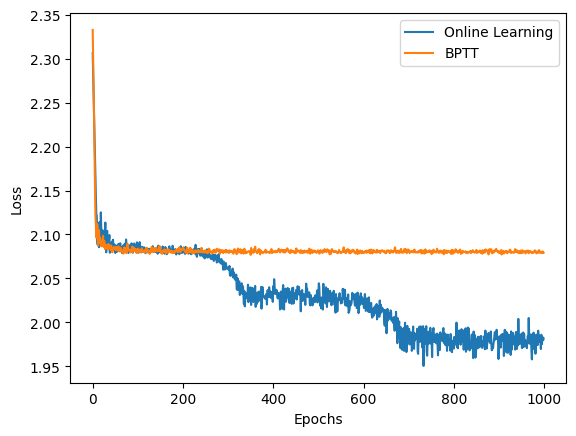

In [9]:
import matplotlib.pyplot as plt

plt.plot(online_losses, label='Online Learning')
plt.plot(bptt_losses, label='BPTT')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## 4. 总结


这份教程全面介绍了如何使用`braintrace`框架实现循环神经网络的在线学习。值得注意的是，`braintrace`特别适合像LSTM和GRU这样具有门控机制的复杂RNN模型。对于像Vanilla RNN这样只有权重交互导致recurrence的RNN模型，`braintrace`在线学习系统很难支持精确的梯度计算。

我们希望这份教程能帮助研究人员和工程师更好地将``braintrace``的在线学习系统用于解决RNNs实际工程训练中的问题。
